## Binary classifier - Logistic

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV
import random

random.seed(37)

df = pd.read_csv('utils/C_npf_train.csv')
Y4 = df['class4']
df = df.drop(['class4', 'class2'], axis=1)
x_train4, x_test4, y_train4, y_test4 = train_test_split(df, Y4, test_size=0.25, random_state=0)

## Multi-label classifier - Logistic

In [165]:
# initialize model
params = dict({'multi_class': 'multinomial', 'class_weight': 'balanced', 'n_jobs': -1})
logReg4 = LogisticRegression(**params)

# feature selection
# using 10-fold cross-validation
logReg4_rfecv = RFECV(
  estimator=logReg4,
  step=1,
  cv=10,
  scoring="accuracy",
  min_features_to_select=1
)
logReg4_rfecv.fit(x_train4, y_train4)

RFECV(cv=10,
      estimator=LogisticRegression(class_weight='balanced',
                                   multi_class='multinomial', n_jobs=-1),
      scoring='accuracy')

0.5304347826086957


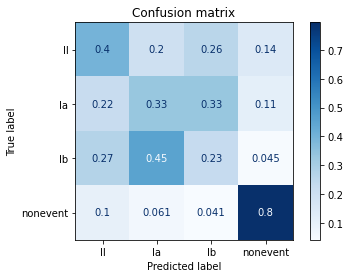

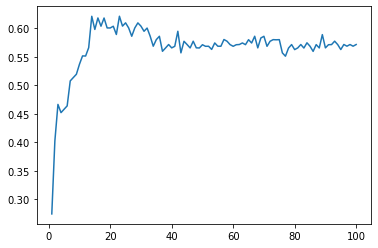

In [166]:
# plotting interediate results
acc4 = logReg4_rfecv.score(x_test4, y_test4)
print(acc4)

conf = plot_confusion_matrix(logReg4_rfecv, x_test4, y_test4,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix')
plt.show(conf)
plt.show()

plt.plot(
    range(1, len(logReg4_rfecv.grid_scores_) + 1),
    logReg4_rfecv.grid_scores_,
)

In [167]:
#best features
df_fe = df.loc[: , logReg4_rfecv.support_]
x_train4fe, x_test4fe, y_train4fe, y_test4fe = train_test_split(df_fe, Y4, test_size=0.25, random_state=0)

In [171]:
# tuning hyper parameters

search_space = dict(
  {'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
  'penalty': ['l1', 'l2', 'elasticnet'],
  'C': [0.01, 0.1, 0.5, 1, 2, 5, 10],
  })

tuner = RandomizedSearchCV(logReg4, search_space, scoring='accuracy', cv=10, n_jobs=-1)
logReg4_param = tuner.fit(x_train4, y_train4)

C:\Users\Adiel\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.59781513 0.58319328        nan        nan
        nan 0.56605042        nan        nan]
  warnings.warn(
C:\Users\Adiel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


0.5978151260504202
{'solver': 'saga', 'penalty': 'l1', 'C': 5}


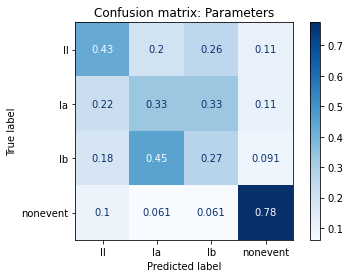

0.5391304347826087


In [173]:
print(logReg4_param.best_score_)
print(logReg4_param.best_params_)

conf_param = plot_confusion_matrix(logReg4_param, x_test4, y_test4,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix: Parameters')
plt.show(conf_param)
plt.show()

acc = logReg4_param.score(x_test4, y_test4)
print(acc)

C:\Users\Adiel\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


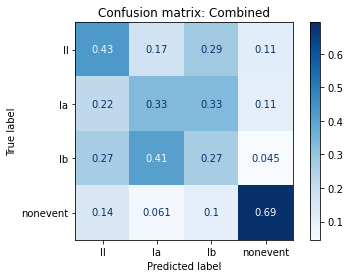

0.5043478260869565


In [175]:
# Combining results
best_params = logReg4_param.best_params_
best_params.update(params)

logReg4_comb = LogisticRegression(**best_params)
logReg4_comb.fit(x_train4fe, y_train4fe)

conf_comb = plot_confusion_matrix(logReg4_comb, x_test4fe, y_test4fe,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix: Combined')
plt.show(conf_comb)
plt.show()

acc = logReg4_comb.score(x_test4fe, y_test4fe)
print(acc)